In [160]:
# mount Google Drive to get the kaggle.json
from google.colab import drive
drive.mount('/content/gdrive', readonly=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [161]:
# install kaggle cli tool and move the kaggle.json to the correct directory
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/ml-project/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [162]:
# download the SMP 500 dataset which has stock data about the SMP 500 companies
# updated daily
!kaggle datasets download -d andrewmvd/sp-500-stocks

sp-500-stocks.zip: Skipping, found more recently modified local copy (use --force to force download)


In [164]:
from zipfile import PyZipFile

# extract the data from the ZIP file
zipfile = PyZipFile('sp-500-stocks.zip')
zipfile.extractall()

In [165]:
import pandas as pd

# read stock data
df_stocks = pd.read_csv('sp500_stocks.csv', parse_dates=['Date'])
# drop extra column
df_stocks.drop(labels=['Adj Close'], axis=1, inplace=True)
# drop any rows that contain missing values
# df_stocks.dropna(inplace=True)
# Make symbol an index for identifying data associated with a stock
df_stocks.set_index('Symbol', inplace=True)
# group by the index 'Symbol'
grouped = df_stocks.groupby(level=0)
# create a dictionary of dataframes where the key is the stock symbol and the
# value is the stock data associated with the symbol
df_stocks_dict = {group: group_df for group, group_df in grouped}
# reset the symbol index, as it does not uniquely define each dataframe row
for df in df_stocks_dict.values():
  df.reset_index(drop=True, inplace=True)

In [166]:
mydf = df_stocks_dict['AAPL'].copy()
mydf.head()

,Date,Close,High,Low,Open,Volume
0,2010-01-04,7.643214,7.660714,7.585000,7.622500,493729600.0
1,2010-01-05,7.656429,7.699643,7.616071,7.664286,601904800.0
2,2010-01-06,7.534643,7.686786,7.526786,7.656429,552160000.0
3,2010-01-07,7.520714,7.571429,7.466071,7.562500,477131200.0
4,2010-01-08,7.570714,7.571429,7.466429,7.510714,447610800.0


In [167]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598 entries, 0 to 3597
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3598 non-null   datetime64[ns]
 1   Close   3598 non-null   float64       
 2   High    3598 non-null   float64       
 3   Low     3598 non-null   float64       
 4   Open    3598 non-null   float64       
 5   Volume  3598 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 168.8 KB


Text(0.5, 1.0, 'Volume')

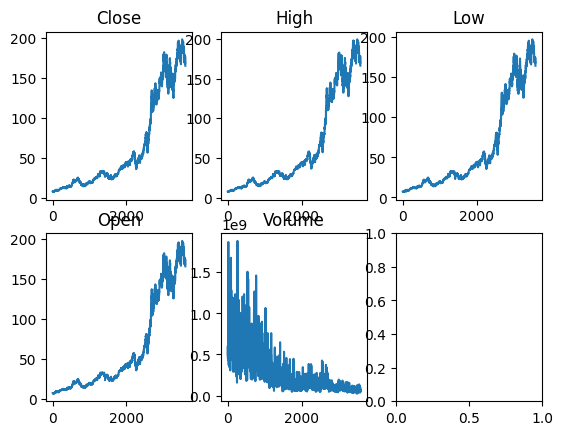

In [168]:
import matplotlib.pyplot as plt

# graph plots of data
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(mydf['Close'])
axs[0, 0].set_title('Close')
axs[0, 1].plot(mydf['High'])
axs[0, 1].set_title('High')
axs[0, 2].plot(mydf['Low'])
axs[0, 2].set_title('Low')
axs[1, 0].plot(mydf['Open'])
axs[1, 0].set_title('Open')
axs[1, 1].plot(mydf['Volume'])
axs[1, 1].set_title('Volume')

# Data Preprocessing

<class 'pandas.core.frame.DataFrame'>
Index: 3597 entries, 1 to 3597
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3597 non-null   float64
 1   High    3597 non-null   float64
 2   Low     3597 non-null   float64
 3   Open    3597 non-null   float64
 4   Volume  3597 non-null   float64
dtypes: float64(5)
memory usage: 168.6 KB


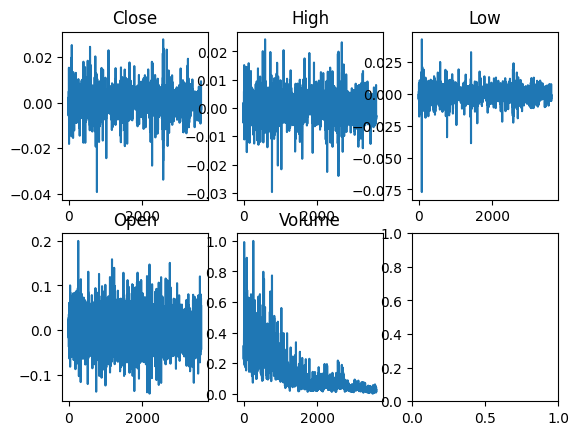

In [169]:
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler

# make the data stationary, as this improves prediction accuracy for RNNs
def price_transform(df):
  df_log = df.apply(np.log)
  df_tf = df_log.apply(np.sqrt)
  df_shift = df_tf - df_tf.shift()
  return (df_shift, df_tf)

# make new dataframe with stationary data
# also get the unshifted but transformed (log & sqrt) data
mydf_stationary = mydf.copy()
mydf_stationary['Close'], mydf_close_tf = price_transform(mydf_stationary['Close'])
mydf_stationary['High'], mydf_high_tf = price_transform(mydf_stationary['High'])
mydf_stationary['Low'], mydf_low_tf = price_transform(mydf_stationary['Low'])
mydf_stationary['Open'], mydf_open_tf = price_transform(mydf_stationary['Volume'])

# Volume does not change like the prices, so normalize it instead
sc = MinMaxScaler(feature_range = (0, 1))
scaler = sc.fit(mydf_stationary['Volume'].to_numpy().reshape(-1, 1))
mydf_stationary['Volume'] = scaler.transform(mydf_stationary['Volume'].to_numpy().reshape(-1, 1))

# Drop null values and Date
mydf_stationary.dropna(inplace=True)
mydf_stationary.drop('Date', axis=1, inplace=True)

# graph the new stationary data
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(mydf_stationary['Close'])
axs[0, 0].set_title('Close')
axs[0, 1].plot(mydf_stationary['High'])
axs[0, 1].set_title('High')
axs[0, 2].plot(mydf_stationary['Low'])
axs[0, 2].set_title('Low')
axs[1, 0].plot(mydf_stationary['Open'])
axs[1, 0].set_title('Open')
axs[1, 1].plot(mydf_stationary['Volume'])
axs[1, 1].set_title('Volume')
mydf_stationary.info()

In [170]:
print(mydf_stationary['Close'].head())
print(mydf_close_tf.head())

1    0.000606
2   -0.005630
3   -0.000651
4    0.002331
5   -0.003117
Name: Close, dtype: float64
0    1.426120
1    1.426726
2    1.421095
3    1.420444
4    1.422775
Name: Close, dtype: float64


# One Day in the Future

In [171]:
def preprocess_lstm(sequence, n_steps, n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if it is beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [172]:
# choose the number of days on which to base our predictions
n_base_instances = 60

# number of features in the dataframe
n_features = 1

# get the inputs and targets in the shape (batch_size, timesteps, features) and (batch_size), respectively
X, y = preprocess_lstm(mydf_stationary['Close'].to_numpy(), n_base_instances, n_features)

In [173]:
print(X.shape)
print(y.shape)

(3537, 60, 1)
(3537,)


In [174]:
test_days = 365

# split into train and test sets
X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

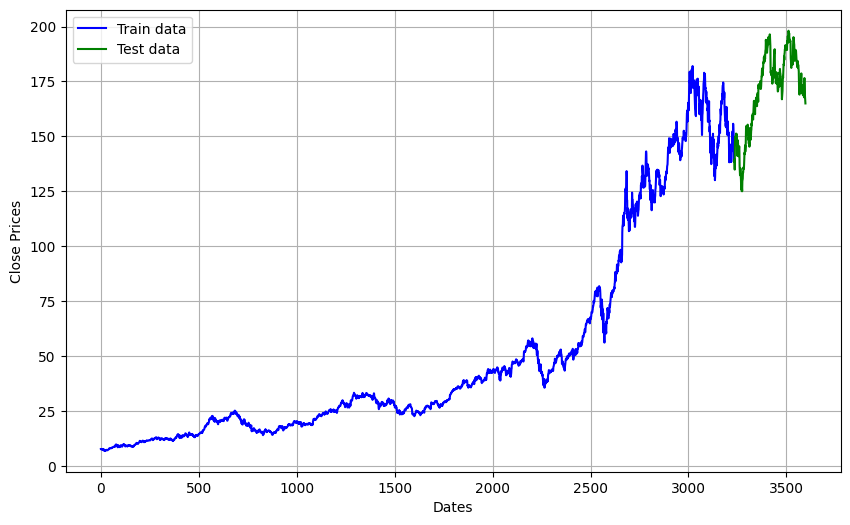

In [175]:
# get the original values for Close price
train_original = mydf['Close'].iloc[:-test_days]
test_original = mydf['Close'].iloc[-test_days:]

# graph original Close price values
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# LSTM with 1 LSTM layer and 1 Dense layer
# predicts 1 day in the future
def vanilla_LSTM():
    lstm = keras.Sequential()
    lstm.add(layers.LSTM(units=50, input_shape=(n_base_instances, n_features)))
    lstm.add(layers.Dense(1))
    return lstm

In [177]:
lstm = vanilla_LSTM()
lstm.summary()
lstm.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [178]:
lstm.fit(X_train, y_train, epochs=15, batch_size = 32)

Epoch 1/15
100/100 [==============================] - 3s 9ms/step - loss: 4.4811e-05 - mean_absolute_error: 0.0052
Epoch 2/15
100/100 [==============================] - 1s 9ms/step - loss: 4.0835e-05 - mean_absolute_error: 0.0049
Epoch 3/15
100/100 [==============================] - 1s 8ms/step - loss: 3.8270e-05 - mean_absolute_error: 0.0048
Epoch 4/15
100/100 [==============================] - 1s 6ms/step - loss: 4.0480e-05 - mean_absolute_error: 0.0049
Epoch 5/15
100/100 [==============================] - 1s 6ms/step - loss: 3.9901e-05 - mean_absolute_error: 0.0048
Epoch 6/15
100/100 [==============================] - 1s 6ms/step - loss: 3.6593e-05 - mean_absolute_error: 0.0046
Epoch 7/15
100/100 [==============================] - 1s 6ms/step - loss: 3.7028e-05 - mean_absolute_error: 0.0047
Epoch 8/15
100/100 [==============================] - 1s 6ms/step - loss: 3.7954e-05 - mean_absolute_error: 0.0048
Epoch 9/15
100/100 [==============================] - 1s 6ms/step - loss: 3.5018

In [179]:
# Evaluate the model on the test data
print("Evaluate on test data")
results = lstm.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 1s 6ms/step - loss: 2.3107e-05 - mean_absolute_error: 0.0040
Test MSE: 2.310659510840196e-05
Test MAE: 0.004005670081824064


12/12 [==============================] - 1s 8ms/step


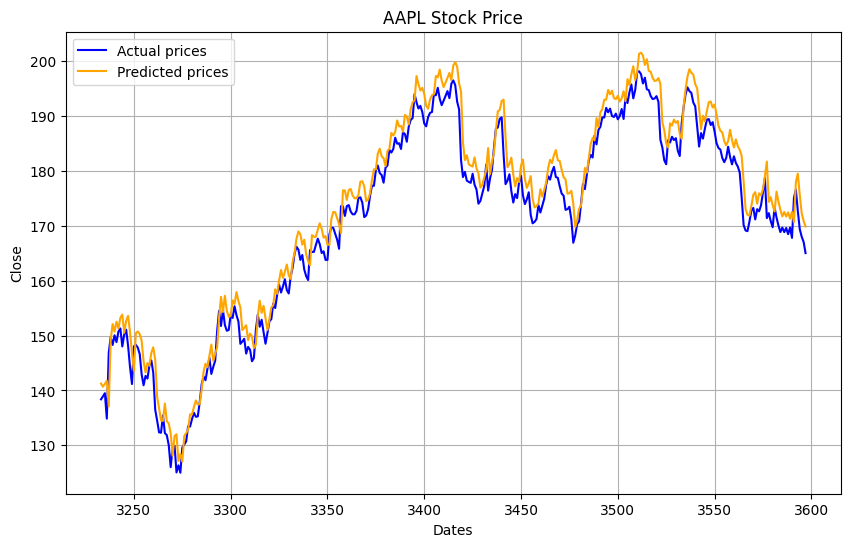

In [180]:
# predict using X_test
y_pred = lstm.predict(X_test)

# create a dataframe from the model predictions
pred_data = pd.DataFrame(y_pred[:, 0], test_original.index, columns=['Close'])

# Reverse the stationary operations

# Reverse the shift operation
pred_data['Close'] = pred_data['Close'] + mydf_close_tf.shift().values[-test_days:]

# Reverse the sqrt and log operations
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title('AAPL Stock Price')
plt.legend()

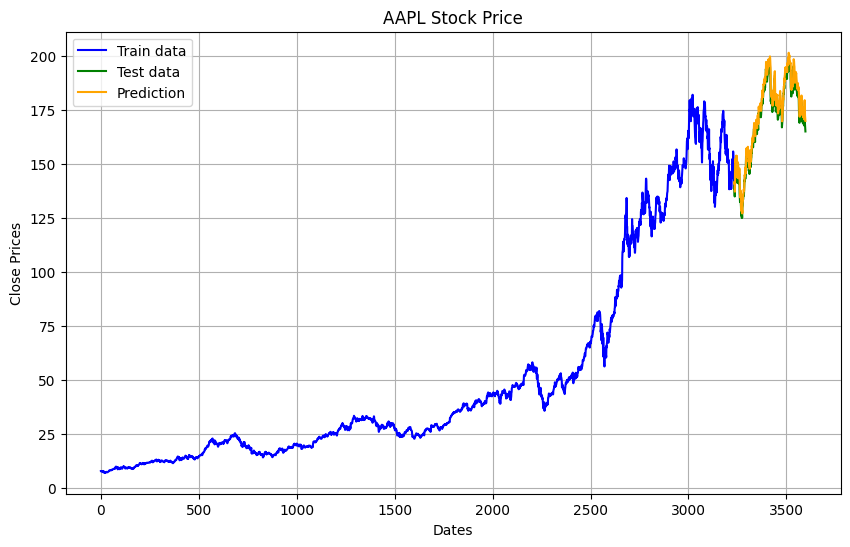

In [181]:
train_original = mydf['Close'].iloc[:-test_days]
test_original = mydf['Close'].iloc[-test_days:]

# plot train data, test data, and predicted values
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
plt.title('AAPL Stock Price')
plt.legend()

## The below transformer is flawed, as the predictions are only zeros.
Adapted from reference #2.

In [182]:
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, attention_axes=None):
    # Attention and Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [183]:
def build_model(
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 60, 1, 1
    inputs = keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs, activation='relu')(x)
    return tf.keras.Model(inputs, outputs)

In [184]:
input_shape = X_train.shape[1:]
print(input_shape)

transformer = build_model(
    head_size=128,
    num_heads=4,
    ff_dim=2,
    num_transformer_blocks=4,
    mlp_units=[256],
    dropout=0.10,
    mlp_dropout=0.10,
)

transformer.compile(
    loss="mse",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    metrics=["mae", 'mape'],
)
transformer.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

transformer.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

results = transformer.evaluate(X_test, y_test, verbose=1)

(60, 1)
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 60, 1)]              0         []                            
                                                                                                  
 layer_normalization_104 (L  (None, 60, 1)                2         ['input_14[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_52 (M  (None, 60, 1)                3585      ['layer_normalization_104[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normali

In [185]:
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Test MSE: 1.0365762136643752e-05
Test MAE: 0.0023750828113406897


12/12 [==============================] - 0s 5ms/step
(365, 1)


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

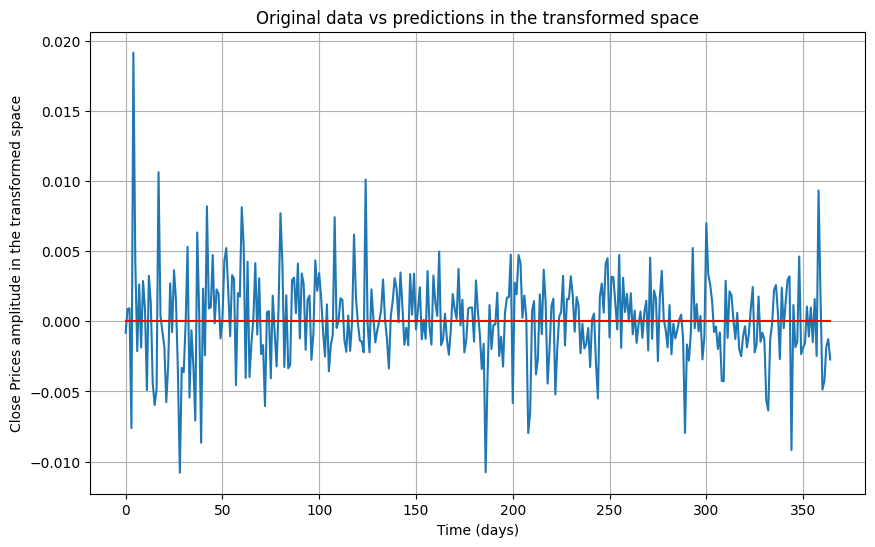

In [186]:
# Prediction
y_pred = transformer.predict(X_test)
print(y_pred.shape)

# Graph test data vs predicted values
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test, label='Orginal data - transformed')
plt.plot(y_pred, color='red', label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Close Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

12/12 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'AAPL Stock Price')

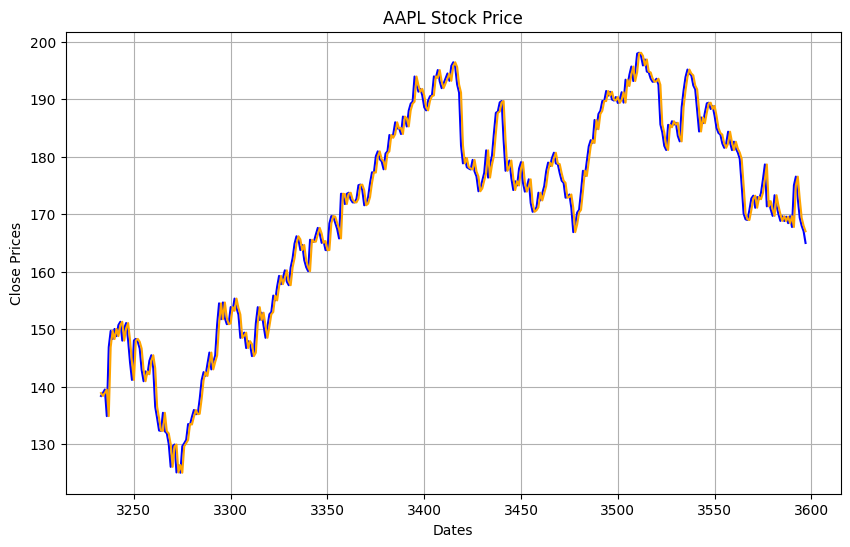

In [187]:
# predict using X_test
y_pred = transformer.predict(X_test)

# create a dataframe from the model predictions
pred_data = pd.DataFrame(y_pred, test_original.index, columns=['Close'])

# Reverse the stationary operations

# Reverse the shift operation
pred_data['Close'] = pred_data['Close'] + mydf_close_tf.shift().values[-test_days:]

# Reverse the sqrt and log operations
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title('AAPL Stock Price')

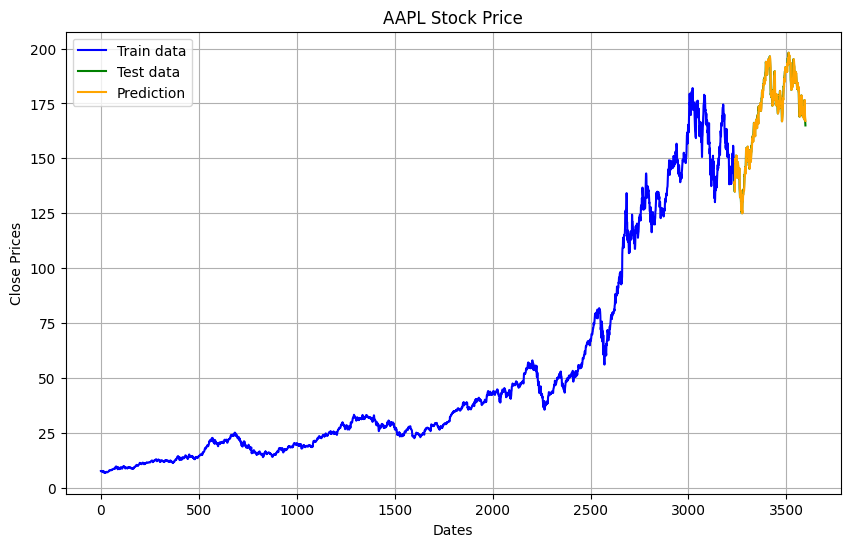

In [188]:
# plot train data, test data, and predicted values
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
plt.title('AAPL Stock Price')
plt.legend()

# Multiple Days in the Future

In [189]:
def preprocess_multistep_model(sequence, n_steps_in, n_steps_out, n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if it is beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence.iloc[i:end_ix], sequence.iloc[end_ix:out_end_ix]
        X.append(seq_x.to_numpy())
        y.append(seq_y.to_numpy())

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

In [190]:
# number of days in the future to predict
n_steps_out = 30

# number of days on which to base the prediction
n_base_instances = 30

# number of features in the dataframe
n_features = 1

# X, y = preprocess_multistep_model(mydf_stationary, n_base_instances, n_steps_out)
X, y = preprocess_multistep_model(mydf_stationary['Close'], n_base_instances, n_steps_out, n_features)

In [191]:
print(X.shape)
print(y.shape)

(3538, 30, 1)
(3538, 30)


In [192]:
test_days = 365

# split into train and test sets
X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

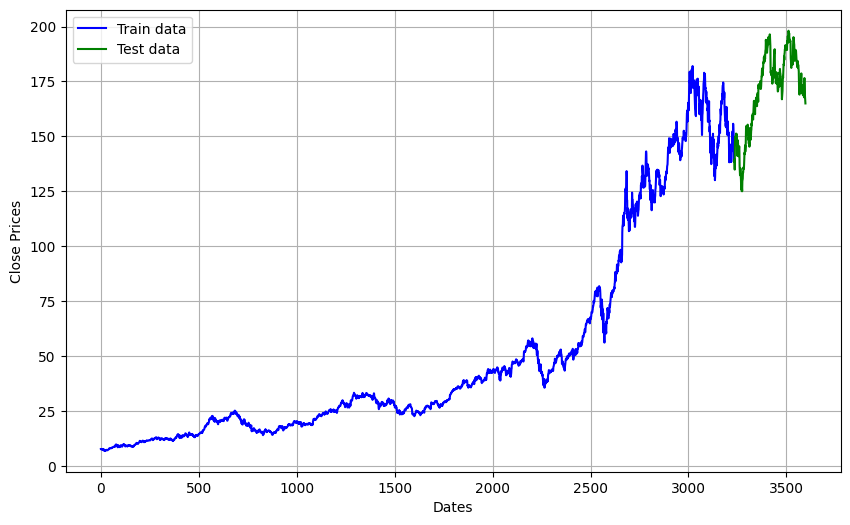

In [193]:
train_original = mydf['Close'].iloc[:-test_days]
test_original = mydf['Close'].iloc[-test_days:]

# graph train data and test data together
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [194]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# LSTM model to predict multiple days in the future
# consists of 1 LSTM layer and 1 Dense layer
def vanilla_multistep_LSTM():
    lstm = keras.Sequential()
    lstm.add(layers.LSTM(units=50, input_shape=(n_base_instances, 1)))
    lstm.add(layers.Dense(n_steps_out))
    return lstm

In [195]:
lstm = vanilla_multistep_LSTM()
lstm.summary()
lstm.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_34 (Dense)            (None, 30)                1530      
                                                                 
Total params: 11930 (46.60 KB)
Trainable params: 11930 (46.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [196]:
lstm.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
100/100 [==============================] - 2s 5ms/step - loss: 2.3303e-05 - mean_absolute_error: 0.0034
Epoch 2/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3354e-05 - mean_absolute_error: 0.0034
Epoch 3/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3349e-05 - mean_absolute_error: 0.0034
Epoch 4/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3359e-05 - mean_absolute_error: 0.0034
Epoch 5/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3313e-05 - mean_absolute_error: 0.0034
Epoch 6/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3330e-05 - mean_absolute_error: 0.0034
Epoch 7/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3299e-05 - mean_absolute_error: 0.0034
Epoch 8/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3363e-05 - mean_absolute_error: 0.0034
Epoch 9/15
100/100 [==============================] - 1s 5ms/step - loss: 2.3314

In [197]:
results = lstm.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

12/12 [==============================] - 1s 7ms/step - loss: 1.2417e-05 - mean_absolute_error: 0.0026
Test MSE: 1.241700283571845e-05
Test MAE: 0.0025823216419667006


12/12 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

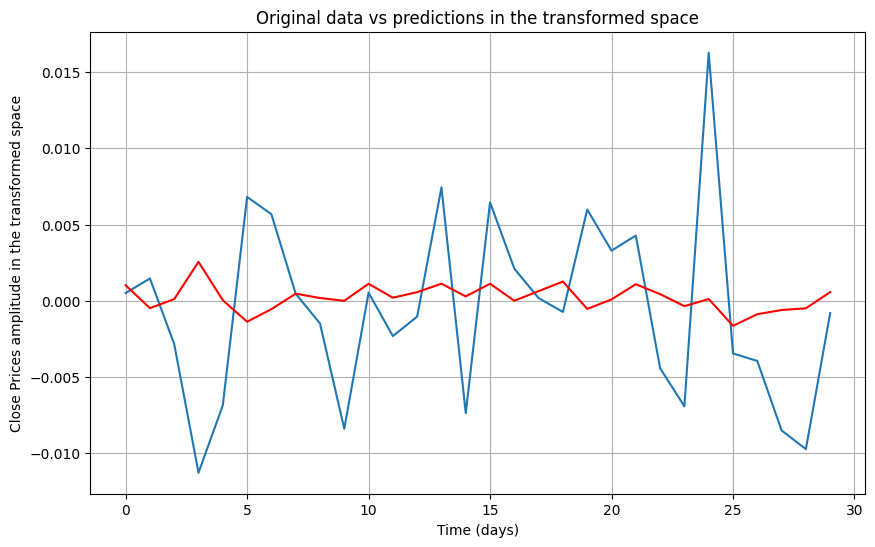

In [198]:
# Prediction
y_pred = lstm.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

# graph the true test data and the predicted values
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Close Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [199]:
# Reverse the staionary operations

# get the cumulative sum of the predicted days
pred_diff_cumsum = y_pred_days.cumsum()

# get the base number
base_number = mydf_close_tf.values[-test_days+the_day+n_base_instances-1]
# get the index range of the true values corresponding to the predicted days
idx = test_original.iloc[the_day:the_day+n_steps_out].index

# get the unshifted values of the prediction
pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum, fill_value=0)
print(pred_tf)

3233    2.214981
3234    2.214496
3235    2.214603
3236    2.217153
3237    2.217189
3238    2.215813
3239    2.215262
3240    2.215724
3241    2.215903
3242    2.215900
3243    2.217012
3244    2.217211
3245    2.217776
3246    2.218894
3247    2.219179
3248    2.220293
3249    2.220292
3250    2.220924
3251    2.222182
3252    2.221646
3253    2.221732
3254    2.222815
3255    2.223249
3256    2.222895
3257    2.223008
3258    2.221362
3259    2.220480
3260    2.219873
3261    2.219378
3262    2.219946
dtype: float64


In [200]:
# Reverse the sqrt and log operations
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

3233    135.116676
3234    134.826766
3235    134.890980
3236    136.424134
3237    136.445985
3238    135.616195
3239    135.285207
3240    135.562676
3241    135.669954
3242    135.668196
3243    136.338470
3244    136.459070
3245    136.801561
3246    137.481561
3247    137.655843
3248    138.337954
3249    138.337671
3250    138.726420
3251    139.503866
3252    139.171821
3253    139.225217
3254    139.896891
3255    140.167494
3256    139.946767
3257    140.017193
3258    138.996832
3259    138.453219
3260    138.080206
3261    137.777310
3262    138.125270
dtype: float64


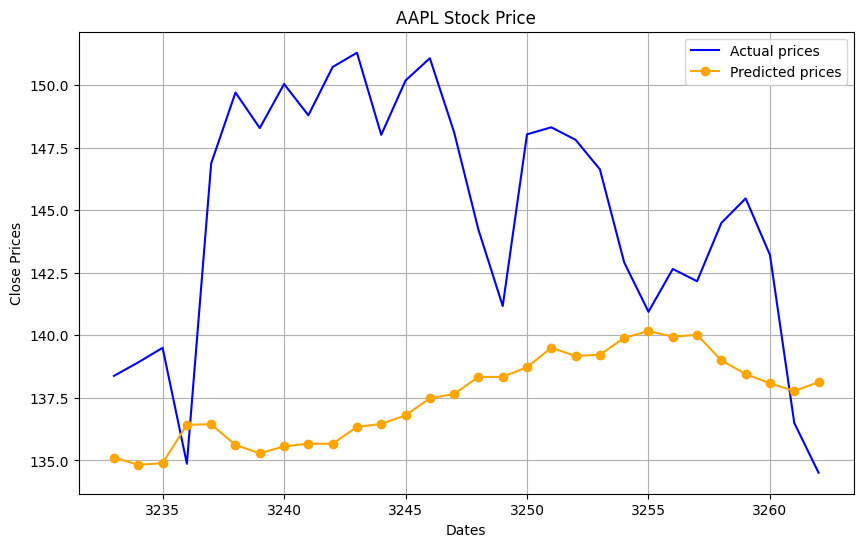

In [201]:
# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title('AAPL Stock Price')

plt.legend()

### I cannot figure out how to make the below model output predictions in the right shape (30, 5).
Considering the problem, it may not make sense to use a transformer model at all, as outputs of the decoder should be fed back through as inputs. If the inputs and outputs are different shapes, then this would cause errors. In addition, this model was based on the transformer for classification in the Keras documentation (shown in references), so there might be some error in adapting it to a regression problem.

In [204]:
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [205]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_outputs=5
):
    """
    Creates final model by building many transformer blocks.
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs, activation='relu')(x)
    return tf.keras.Model(inputs, outputs)

In [206]:
input_shape = X_train.shape[1:]
print(input_shape)

transformer = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.10,
    mlp_dropout=0.10,
    n_outputs=30
)

transformer.compile(
    loss="mse",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    metrics=["mae"],
)
transformer.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

transformer.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

results = transformer.evaluate(X_test, y_test, verbose=1)

(30, 1)
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 30, 1)]              0         []                            
                                                                                                  
 multi_head_attention_56 (M  (None, 30, 1)                7169      ['input_15[0][0]',            
 ultiHeadAttention)                                                  'input_15[0][0]']            
                                                                                                  
 dropout_126 (Dropout)       (None, 30, 1)                0         ['multi_head_attention_56[0][0
                                                                    ]']                           
                                                                                   

In [207]:
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Test MSE: 1.1664196790661663e-05
Test MAE: 0.0024826291482895613


12/12 [==============================] - 0s 6ms/step
[0.0000000e+00 0.0000000e+00 2.6157039e-05 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9808968e-04 3.4999731e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.8892954e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.6979542e-04 0.0000000e+00 0.0000000e+00]


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

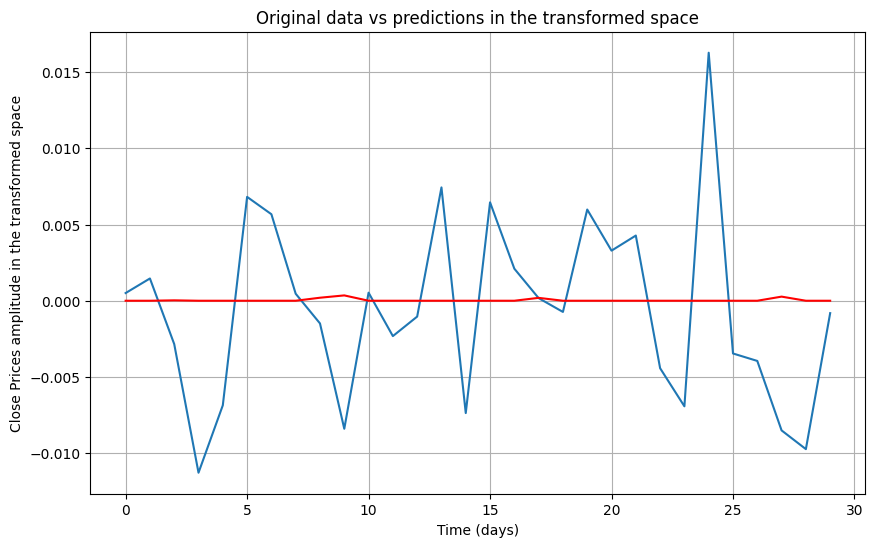

In [209]:
# Prediction
y_pred = transformer.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]
print(y_pred_days)

# graph test data and predicted values
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Close Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [210]:
# Reverse the staionary operations

# get the cumulative sum of the predicted days
pred_diff_cumsum = y_pred_days.cumsum()

# get the base number
base_number = mydf_close_tf.values[-test_days+the_day+n_base_instances-1]
# get the index range of the true values corresponding to the predicted days
idx = test_original.iloc[the_day:the_day+n_steps_out].index

# get the unshifted values of the prediction
pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

3233    2.213964
3234    2.213964
3235    2.213991
3236    2.213991
3237    2.213991
3238    2.213991
3239    2.213991
3240    2.213991
3241    2.214189
3242    2.214539
3243    2.214539
3244    2.214539
3245    2.214539
3246    2.214539
3247    2.214539
3248    2.214539
3249    2.214539
3250    2.214728
3251    2.214728
3252    2.214728
3253    2.214728
3254    2.214728
3255    2.214728
3256    2.214728
3257    2.214728
3258    2.214728
3259    2.214728
3260    2.214997
3261    2.214997
3262    2.214997
dtype: float64


In [211]:
# Reverse the sqrt and log operations
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

3233    134.509995
3234    134.509995
3235    134.525575
3236    134.525575
3237    134.525575
3238    134.525575
3239    134.525575
3240    134.525575
3241    134.643629
3242    134.852494
3243    134.852494
3244    134.852494
3245    134.852494
3246    134.852494
3247    134.852494
3248    134.852494
3249    134.852494
3250    134.965389
3251    134.965389
3252    134.965389
3253    134.965389
3254    134.965389
3255    134.965389
3256    134.965389
3257    134.965389
3258    134.965389
3259    134.965389
3260    135.126785
3261    135.126785
3262    135.126785
dtype: float64


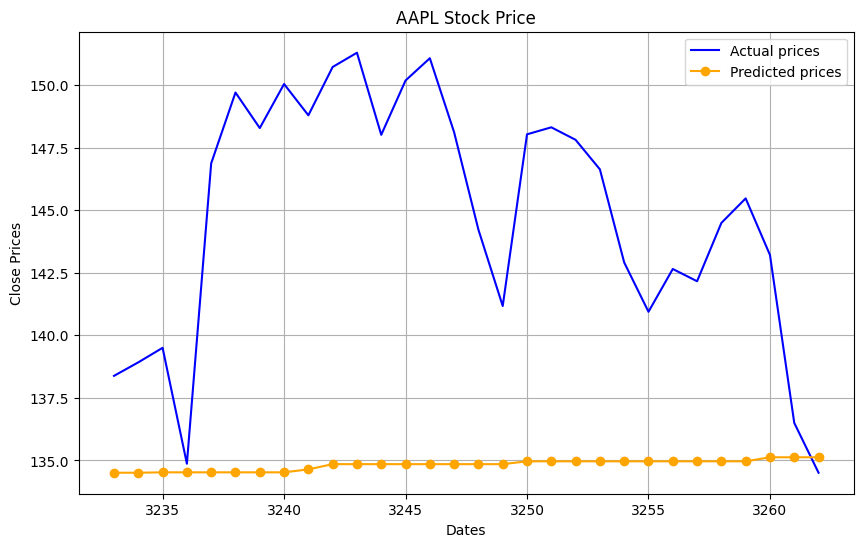

In [212]:
# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title('AAPL Stock Price')

plt.legend()

# References

Code adapted from:
1. https://www.kaggle.com/code/thibauthurson/stock-price-prediction-with-lstm-multi-step-lstm
2. https://medium.com/@mskmay66/transformers-vs-lstm-for-stock-price-time-series-prediction-3a26fcc1a782
3. https://keras.io/examples/timeseries/timeseries_classification_transformer/
